In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
data_train = pd.read_csv('kagle_train.csv.zip', sep=',', parse_dates=['start_time'])
data_test = pd.read_csv('regr_test.csv.zip', sep=',', parse_dates=['start_time'])
idx = data_test['id'].values

In [3]:
data_train.describe()

,id,price,item_id,item_views
count,376687.000000,3.766870e+05,3.766870e+05,376687.000000
mean,211784.700144,2.465498e+05,4.606439e+18,3.483459
std,122355.459807,1.126163e+07,2.663233e+18,1.019757
min,0.000000,0.000000e+00,6.694595e+13,0.000000
25%,105786.500000,5.000000e+02,2.296781e+18,2.708050
50%,211758.000000,2.000000e+03,4.606254e+18,3.367296
75%,317745.500000,9.990000e+03,6.912617e+18,4.094345
max,423771.000000,5.677568e+09,9.223325e+18,8.328693


In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376687 entries, 0 to 376686
Data columns (total 13 columns):
id             376687 non-null int64
start_time     376687 non-null datetime64[ns]
title          376687 non-null object
price          376687 non-null int64
item_id        376687 non-null int64
owner_type     376687 non-null object
category       376687 non-null object
subcategory    376687 non-null object
param1         361456 non-null object
param2         196112 non-null object
param3         147746 non-null object
region         376687 non-null object
item_views     376687 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(3), object(8)
memory usage: 37.4+ MB


### Препроцессинг

In [5]:
data_train = data_train.fillna('nan')
data_test = data_test.fillna('nan')

In [6]:
np.any(data_train.isna())

False

In [7]:
f = lambda x: (x.hour * 60 + x.minute) / (24 * 60)
data_train['relative_time'] = data_train.start_time.apply(f)
data_test['relative_time'] = data_test.start_time.apply(f)

In [8]:
data_train['time_to_end'] = data_train.start_time.apply(lambda x: 24 - x.hour)
data_test['time_to_end'] = data_test.start_time.apply(lambda x: 24 - x.hour)

In [9]:
data_train['slided_hours'] = data_train.start_time.apply(lambda x: ((x.hour - 3.5) % 24) * 1. / 24.)
data_test['slided_hours'] = data_test.start_time.apply(lambda x: ((x.hour - 3.5) % 24) * 1. / 24.)

In [10]:
def make_harmonic_features(value, period=24):
    value = (value / period) * 2 * np.pi
    return np.cos(value), np.sin(value)

In [11]:
data_train['cos_time'] = data_train.start_time.apply(lambda x: make_harmonic_features(x.hour + x.minute / 60)[0])
data_train['sin_time'] = data_train.start_time.apply(lambda x: make_harmonic_features(x.hour + x.minute / 60)[1])

data_test['cos_time'] = data_test.start_time.apply(lambda x: make_harmonic_features(x.hour + x.minute / 60)[0])
data_test['sin_time'] = data_test.start_time.apply(lambda x: make_harmonic_features(x.hour + x.minute / 60)[1])

In [12]:
data_train['week_day'] = data_train.start_time.apply(lambda x: x.isoweekday())
data_test['week_day'] = data_test.start_time.apply(lambda x: x.isoweekday())

In [13]:
data_train = data_train.drop(['start_time'], axis=1)
data_test = data_test.drop(['start_time'], axis=1)

In [14]:
data_train.head()

,id,title,price,item_id,owner_type,category,subcategory,param1,param2,param3,region,item_views,relative_time,time_to_end,slided_hours,cos_time,sin_time,week_day
0,328853,Сандали фирмы Crocs,800,1301822498390501359,Private,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,> 36,Москва,3.332205,0.443056,14,0.270833,-0.936672,0.350207,2
1,257639,Бутсы футбольные Reebok,2000,4439620035274845039,Private,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,> 36,Омская область,2.302585,0.640972,9,0.479167,-0.632705,-0.774393,2
2,140732,Nike hypervenom Бутсы,600,4860577743813309218,Private,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,> 36,Санкт-Петербург,4.663439,0.815278,5,0.645833,0.398749,-0.917060,3
3,3080,Сапоги,150,3492530336858889466,Private,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,> 36,Тульская область,3.367296,0.434722,14,0.270833,-0.917060,0.398749,1
4,325394,Кеды 38,500,3559049054931858928,Private,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,> 36,Самарская область,2.302585,0.714583,7,0.562500,-0.220697,-0.975342,1


In [15]:
def count_upletters(x):
    res = 0
    for letter in x:
        if letter.isupper():
            res += 1
    return res

In [16]:
data_train['upcase'] = data_train['title'].apply(count_upletters)
data_test['upcase'] = data_test['title'].apply(count_upletters)

##### текст

In [17]:
# !pip install pymorphy2

import re
import pymorphy2
from functools import lru_cache

In [18]:
morph = pymorphy2.MorphAnalyzer()

In [19]:
@lru_cache(maxsize=1000000) # с кешом!
def get_normal_form(i):
    return morph.normal_forms(i)[0]

def normalize_text(x):
    return ' '.join([get_normal_form(i) for i in re.findall('\w+', x)])

def del_numbers(x):
    return ''.join([i for i in x if not i.isdigit()])

def rem_spaces(x):
    return re.sub(' +', ' ', x).strip()

def rem_punctuation(x):
    return re.sub('[^A-Za-zА-Яа-я0-9 ]+', '', x)

def get_good_text(x):
    return rem_punctuation(rem_spaces(del_numbers(normalize_text(x))))

In [20]:
get_good_text('Детская одежда135131354313513 и об161увь')

'детский одежда и обувь'

In [21]:
%%time

data_train['title'] = data_train['title'].apply(lambda x: get_good_text(x))
data_train['category'] = data_train['category'].apply(lambda x: get_good_text(x))
data_train['subcategory'] = data_train['subcategory'].apply(lambda x: get_good_text(x))

data_test['title'] = data_test['title'].apply(lambda x: get_good_text(x))
data_test['category'] = data_test['category'].apply(lambda x: get_good_text(x))
data_test['subcategory'] = data_test['subcategory'].apply(lambda x: get_good_text(x))

Wall time: 52.9 s


In [22]:
data_train['fast_bait'] = data_train['title'].apply(lambda x: x.count('срочн'))
data_train['delivery_bait'] = data_train['title'].apply(lambda x: x.count('достав'))
data_train['free_bait'] = data_train['title'].apply(lambda x: x.count('беспл') + x.count('дар'))

data_test['fast_bait'] = data_test['title'].apply(lambda x: x.count('срочн'))
data_test['delivery_bait'] = data_test['title'].apply(lambda x: x.count('достав'))
data_test['free_bait'] = data_test['title'].apply(lambda x: x.count('беспл') + x.count('дар'))

##### Куча категориальных признаков

In [23]:
pd.options.display.max_columns = 50

In [24]:
data_train.columns

Index(['id', 'title', 'price', 'item_id', 'owner_type', 'category',
       'subcategory', 'param1', 'param2', 'param3', 'region', 'item_views',
       'relative_time', 'time_to_end', 'slided_hours', 'cos_time', 'sin_time',
       'week_day', 'upcase', 'fast_bait', 'delivery_bait', 'free_bait'],
      dtype='object')

In [25]:
str_cols = ['title',
            'param1', 'param2', 'param3',
            'owner_type', 'category', 'subcategory',
            'region'
           ]

In [26]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
enc = OneHotEncoder()
vec = TfidfVectorizer(max_features=2000)

In [27]:
title_train = vec.fit_transform(data_train['title'])
title_test = vec.transform(data_test['title'])

In [28]:
owners_train_dummies = enc.fit_transform(data_train[['owner_type']])
owners_test_dummies = enc.transform(data_test[['owner_type']])

cat_train_dummies = enc.fit_transform(data_train[['category']])
cat_test_dummies = enc.transform(data_test[['category']])

subcat_train_dummies = enc.fit_transform(data_train[['subcategory']])
subcat_test_dummies = enc.transform(data_test[['subcategory']])

region_train_dummies = enc.fit_transform(data_train[['region']])
region_test_dummies = enc.transform(data_test[['region']])

In [29]:
data_train.drop(columns=str_cols, inplace=True)
data_test.drop(columns=str_cols, inplace=True)

In [30]:
data_train, y = data_train.drop(['item_views', 'id', 'item_id'], axis=1), data_train['item_views'].values
data_test = data_test.drop(['id', 'item_id'], axis=1)

In [31]:
data_train.head()

,price,relative_time,time_to_end,slided_hours,cos_time,sin_time,week_day,upcase,fast_bait,delivery_bait,free_bait
0,800,0.443056,14,0.270833,-0.936672,0.350207,2,2,0,0,0
1,2000,0.640972,9,0.479167,-0.632705,-0.774393,2,2,0,0,0
2,600,0.815278,5,0.645833,0.398749,-0.917060,3,2,0,0,0
3,150,0.434722,14,0.270833,-0.917060,0.398749,1,1,0,0,0
4,500,0.714583,7,0.562500,-0.220697,-0.975342,1,1,0,0,0


In [32]:
from sklearn.preprocessing import PolynomialFeatures

In [33]:
poly = PolynomialFeatures(degree=3)

data_train = poly.fit_transform(data_train)
data_test = poly.transform(data_test)

In [34]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()

data_train = scaler.fit_transform(data_train)
data_test = scaler.transform(data_test)

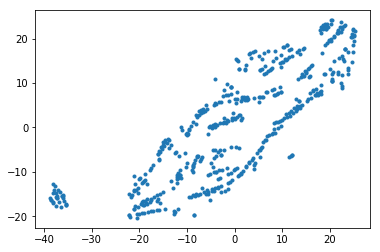

In [35]:
from sklearn.manifold import TSNE


tsne = TSNE(n_components=2)
res = tsne.fit_transform(data_train[np.random.choice(data_train.shape[0], 500, replace=False), :])

plt.scatter(res[:, 0], res[:, 1], marker='.')

In [36]:
import scipy.sparse as sp

In [37]:
data_train = sp.hstack([data_train, owners_train_dummies, 
                        cat_train_dummies, subcat_train_dummies, 
                        region_train_dummies, title_train])

data_test = sp.hstack([data_test, owners_test_dummies, 
                       cat_test_dummies, subcat_test_dummies, 
                       region_test_dummies, title_test])

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_train, y, random_state=11)

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, KFold


In [ ]:
lr = LinearRegression()
cvs = cross_val_score(lr, X_train, y_train, cv=cv, 
                      scoring=make_scorer(mse))
np.sqrt(cvs.mean())

In [41]:
lr = LinearRegression()
lr.fit(data_train, y)
preds = lr.predict(data_test)

In [42]:
pd.DataFrame({'id': idx, 'item_views': preds}).to_csv('out_linreg.csv', index=None)

In [33]:
pd.read_csv('out_linreg.csv').head()

,id,item_views
0,161539,2.775931
1,72401,2.552044
2,387692,2.559968
3,163041,3.027857
4,367881,2.657056
